In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Ex. 6

In [3]:
dataset_file = '../datasets/Wage.csv'
data = pd.read_csv(dataset_file, index_col=0)
data.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [4]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [5]:
degrees = np.arange(1, 11)
metrics = pd.Series(dtype=np.float64, index=degrees)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
for degree in degrees:
    errors = []
    for train, test in cv.split(data):
        model = sm.OLS(
            data.wage.iloc[train],
            PolynomialFeatures(degree=degree).fit_transform(data.age.iloc[train].to_frame())
        ).fit()
        errors.append(mean_squared_error(
            data.wage.iloc[test],
            model.predict(PolynomialFeatures(degree=degree).fit_transform(data.age.iloc[test].to_frame()))
        ))
    metrics.loc[degree] = np.mean(errors)

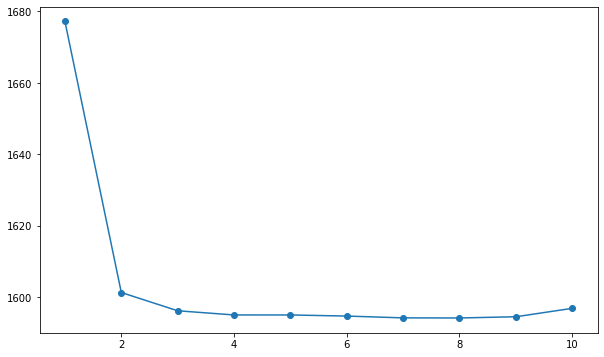

In [6]:
plt.figure(figsize=(10,6))
plt.plot(metrics.index, metrics, 'o-')
best_cv = metrics.idxmin()

In [7]:
models = [sm.OLS(data.wage, PolynomialFeatures(degree=degree).fit_transform(data.age.to_frame())).fit() for degree in degrees]
sm.stats.anova_lm(*models)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.518656,2.449930e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.883629,1.683872e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.807838,5.110636e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804558,3.698061e-01
5,2993.0,4.766389e+06,1.0,3932.257631,2.466726,1.163856e-01
6,2993.0,4.764599e+06,-0.0,1790.494628,-inf,NaN
7,2993.0,4.764136e+06,-0.0,462.435544,-inf,NaN
8,2993.0,4.764981e+06,-0.0,-844.242937,inf,NaN
9,2993.0,4.771202e+06,-0.0,-6221.454329,inf,NaN


ANOVA shows that using models with degree higher than 2 is inefficient, however CV suggests the model of degree 7.

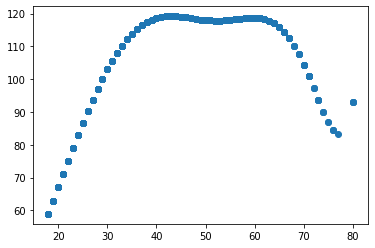

In [8]:
model = sm.OLS(data.wage, PolynomialFeatures(degree=best_cv).fit_transform(data.age.to_frame())).fit()
plt.plot(data.age, model.predict(PolynomialFeatures(degree=best_cv).fit_transform(data.age.to_frame())), 'o')

In [9]:
cuts_nums = np.arange(1, 21)
metrics = pd.Series(dtype=np.float64, index=cuts_nums)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
for cuts_num in cuts_nums:
    errors = []
    for train, test in cv.split(data):
        cut_age_train, bins = pd.cut(data.age.iloc[train], cuts_num, retbins=True)
        cut_age_train = pd.get_dummies(cut_age_train).iloc[:, 1:]
        cut_age_test = pd.cut(data.age.iloc[test], bins=bins)
        cut_age_test = pd.get_dummies(cut_age_test).iloc[:, 1:]
        model = sm.OLS(
            data.wage.iloc[train],
            sm.add_constant(cut_age_train)
        ).fit()
        errors.append(mean_squared_error(
            data.wage.iloc[test],
            model.predict(sm.add_constant(cut_age_test))
        ))
    metrics.loc[cuts_num] = np.mean(errors)

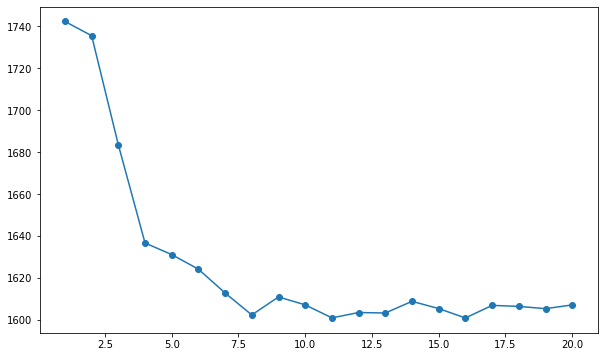

In [10]:
plt.figure(figsize=(10,6))
plt.plot(metrics.index, metrics, 'o-')
best_cv = metrics.idxmin()

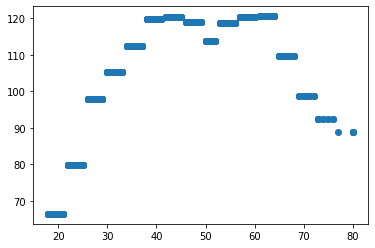

In [11]:
cut_age = pd.cut(data.age, best_cv)
cut_age = pd.get_dummies(cut_age).iloc[:, 1:]
model = sm.OLS(data.wage, sm.add_constant(cut_age)).fit()
plt.plot(data.age, model.predict(sm.add_constant(cut_age)), 'o')

# Ex. 7

Categorical variables cannot be transformed.

In [12]:
maritl = pd.get_dummies(data.maritl).drop(['5. Separated'], axis=1)
race = pd.get_dummies(data.race).drop(['4. Other'], axis=1)
data['job_industrial'] = data.jobclass.apply(lambda v: 1 if v.startswith('1') else 0)
data['health_good'] = data.health.apply(lambda v: 1 if v.startswith('1') else 0)
data['health_ins_ok'] = data.health_ins.apply(lambda v: 1 if v.startswith('1') else 0)

In [13]:
data.columns

Index(['year', 'age', 'maritl', 'race', 'education', 'region', 'jobclass',
       'health', 'health_ins', 'logwage', 'wage', 'job_industrial',
       'health_good', 'health_ins_ok'],
      dtype='object')

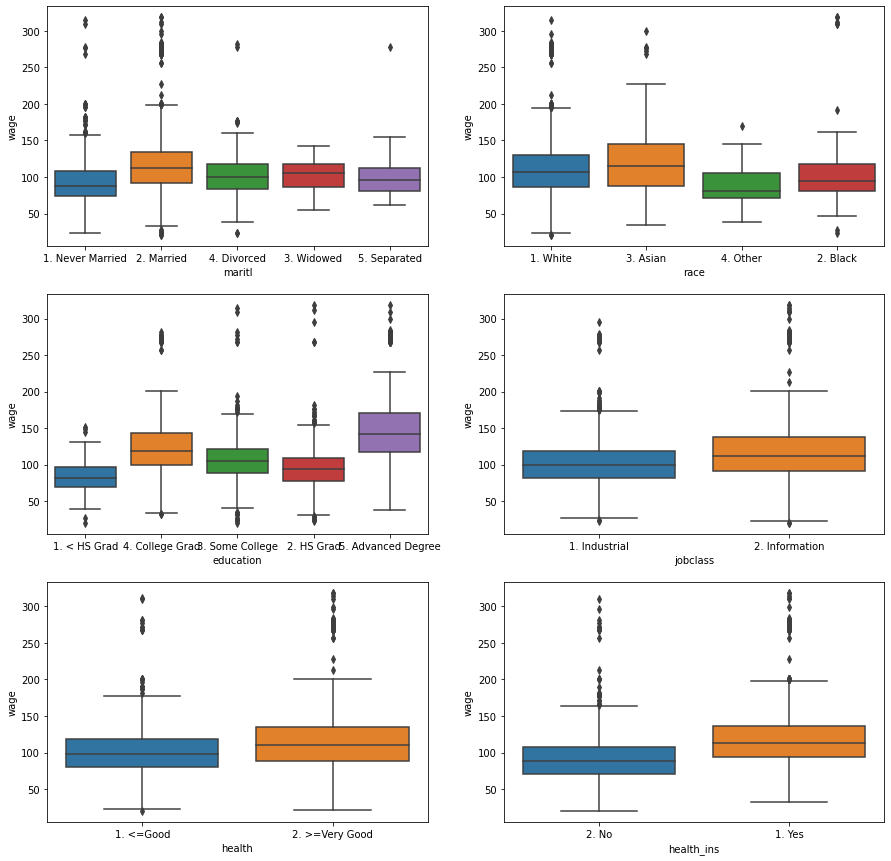

In [14]:
_, axes = plt.subplots(3, 2, figsize=(15, 15))
for i, col in enumerate(['maritl', 'race', 'education', 'jobclass', 'health', 'health_ins']):
    sns.boxplot(data[col], data.wage, ax=axes[i//2, i%2])


In [15]:
model = sm.OLS.from_formula('wage ~ health_good + health_ins_ok + job_industrial', data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     157.2
Date:                Sun, 27 Sep 2020   Prob (F-statistic):           1.34e-94
Time:                        12:33:19   Log-Likelihood:                -15231.
No. Observations:                3000   AIC:                         3.047e+04
Df Residuals:                    2996   BIC:                         3.049e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        104.3387      1.638     63.705      0.000     101.127     107.550
health_good      -11.1443      1.575     -7.076      0.000     -14.233      -8.056
health_ins_ok     24.9554      1.559     16.008      0.000      21.899      28.012
job_industrial   -13.1643      1.436     -9.167      0.000     -15.980     -10.349
==============================================================================
Omnibus:                     1144.569   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5285.499
Skew:                           1.798   Prob(JB):                         0.00
Kurtosis:                       8.418   Cond. No.                         4.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
model = sm.OLS(data.wage, sm.add_constant(maritl)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     55.96
Date:                Sun, 27 Sep 2020   Prob (F-statistic):           1.40e-45
Time:                        12:33:19   Log-Likelihood:                -15342.
No. Observations:                3000   AIC:                         3.069e+04
Df Residuals:                    2995   BIC:                         3.072e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              101.2158      5.431     18.636      0.000      90.567     111.865
1. Never Married    -8.4811      5.657     -1.499      0.134     -19.573       2.611
2. Married          17.6445      5.503      3.207      0.001       6.855      28.434
3. Widowed          -1.6771     10.718     -0.156      0.876     -22.693      19.339
4. Divorced          1.9435      6.120      0.318      0.751     -10.056      13.943
==============================================================================
Omnibus:                     1092.638   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4899.270
Skew:                           1.716   Prob(JB):                         0.00
Kurtosis:                       8.236   Cond. No.                         22.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
model = sm.OLS(data.wage, sm.add_constant(pd.concat([data[['health_good', 'health_ins_ok', 'job_industrial']], maritl], axis=1))).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     100.1
Date:                Sun, 27 Sep 2020   Prob (F-statistic):          8.80e-132
Time:                        12:33:20   Log-Likelihood:                -15134.
No. Observations:                3000   AIC:                         3.028e+04
Df Residuals:                    2992   BIC:                         3.033e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               95.9411      5.248     18.282      0.000      85.651     106.231
health_good        -10.6754      1.530     -6.979      0.000     -13.675      -7.676
health_ins_ok       23.2482      1.518     15.316      0.000      20.272      26.224
job_industrial     -12.7471      1.392     -9.155      0.000     -15.477     -10.017
1. Never Married    -7.2909      5.283     -1.380      0.168     -17.650       3.068
2. Married          15.5921      5.140      3.033      0.002       5.514      25.670
3. Widowed          -1.5489     10.012     -0.155      0.877     -21.179      18.081
4. Divorced          0.5800      5.717      0.101      0.919     -10.630      11.790
==============================================================================
Omnibus:                     1170.911   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5804.546
Skew:                           1.817   Prob(JB):                         0.00
Kurtosis:                       8.765   Cond. No.                         28.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It's seen that considered variables don't explain much variance in `wage`.

# Ex. 8

In [18]:
dataset_file = '../datasets/Auto.csv'
data = pd.read_csv(dataset_file)
data = data.loc[data.horsepower != '?']
data.horsepower = data.horsepower.apply(int)
data.head()

/home/ivan2/projects/ISLR/venv/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


Text(0.5, 1.0, 'Horsepower. Best: 5')

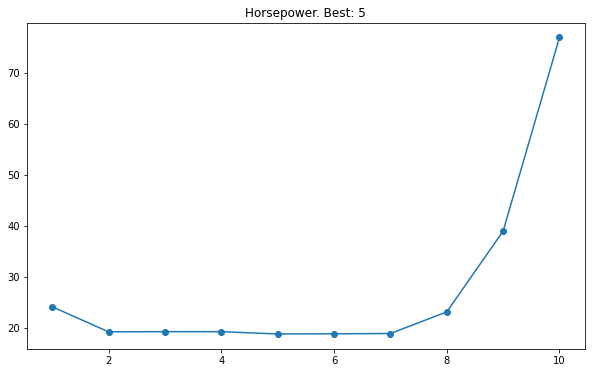

In [19]:
degrees = np.arange(1, 11)
metrics = pd.Series(dtype=np.float64, index=degrees)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
for degree in degrees:
    errors = []
    for train, test in cv.split(data):
        model = sm.OLS(
            data.mpg.iloc[train],
            PolynomialFeatures(degree=degree).fit_transform(data.horsepower.iloc[train].to_frame())
        ).fit()
        errors.append(mean_squared_error(
            data.mpg.iloc[test],
            model.predict(PolynomialFeatures(degree=degree).fit_transform(data.horsepower.iloc[test].to_frame()))
        ))
    metrics.loc[degree] = np.mean(errors)

plt.figure(figsize=(10,6))
plt.plot(metrics.index, metrics, 'o-')
best_cv = metrics.idxmin()
plt.title(f'Horsepower. Best: {best_cv}')

Text(0.5, 1.0, 'Displacement. Best: 6')

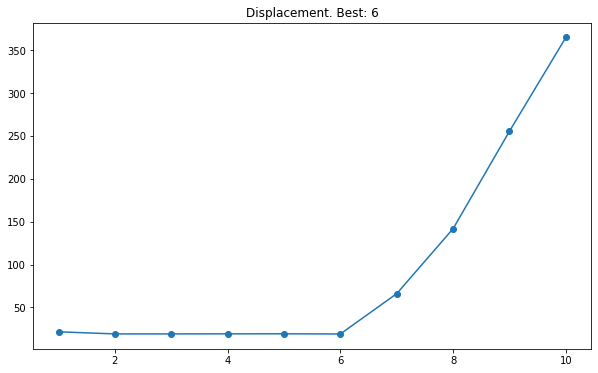

In [20]:
degrees = np.arange(1, 11)
metrics = pd.Series(dtype=np.float64, index=degrees)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
for degree in degrees:
    errors = []
    for train, test in cv.split(data):
        model = sm.OLS(
            data.mpg.iloc[train],
            PolynomialFeatures(degree=degree).fit_transform(data.displacement.iloc[train].to_frame())
        ).fit()
        errors.append(mean_squared_error(
            data.mpg.iloc[test],
            model.predict(PolynomialFeatures(degree=degree).fit_transform(data.displacement.iloc[test].to_frame()))
        ))
    metrics.loc[degree] = np.mean(errors)

plt.figure(figsize=(10,6))
plt.plot(metrics.index, metrics, 'o-')
best_cv = metrics.idxmin()
plt.title(f'Displacement. Best: {best_cv}')

Text(0.5, 1.0, 'Horsepower. Best: 15')

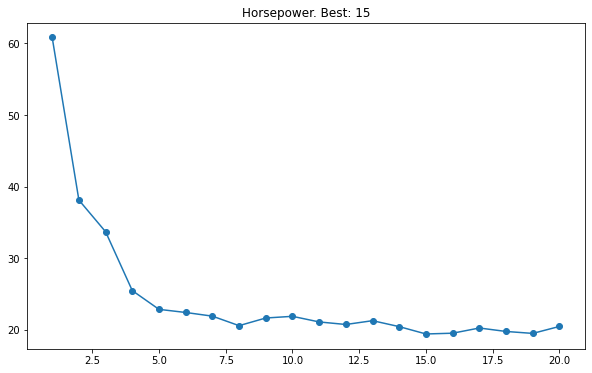

In [21]:
cuts_nums = np.arange(1, 21)
metrics = pd.Series(dtype=np.float64, index=cuts_nums)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
for cuts_num in cuts_nums:
    errors = []
    for train, test in cv.split(data):
        cut_horsepower_train, bins = pd.cut(data.horsepower.iloc[train], cuts_num, retbins=True)
        cut_horsepower_train = pd.get_dummies(cut_horsepower_train).iloc[:, 1:]
        cut_horsepower_test = pd.cut(data.horsepower.iloc[test], bins=bins)
        cut_horsepower_test = pd.get_dummies(cut_horsepower_test).iloc[:, 1:]
        model = sm.OLS(
            data.mpg.iloc[train],
            sm.add_constant(cut_horsepower_train)
        ).fit()
        errors.append(mean_squared_error(
            data.mpg.iloc[test],
            model.predict(sm.add_constant(cut_horsepower_test))
        ))
    metrics.loc[cuts_num] = np.mean(errors)

plt.figure(figsize=(10,6))
plt.plot(metrics.index, metrics, 'o-')
best_cv = metrics.idxmin()
plt.title(f'Horsepower. Best: {best_cv}')

Text(0.5, 1.0, 'Displacement. Best: 9')

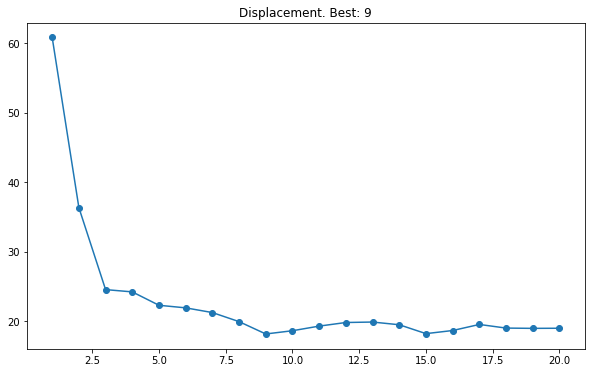

In [22]:
cuts_nums = np.arange(1, 21)
metrics = pd.Series(dtype=np.float64, index=cuts_nums)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
for cuts_num in cuts_nums:
    errors = []
    for train, test in cv.split(data):
        cut_displacement_train, bins = pd.cut(data.displacement.iloc[train], cuts_num, retbins=True)
        cut_displacement_train = pd.get_dummies(cut_displacement_train).iloc[:, 1:]
        cut_displacement_test = pd.cut(data.displacement.iloc[test], bins=bins)
        cut_displacement_test = pd.get_dummies(cut_displacement_test).iloc[:, 1:]
        model = sm.OLS(
            data.mpg.iloc[train],
            sm.add_constant(cut_displacement_train)
        ).fit()
        errors.append(mean_squared_error(
            data.mpg.iloc[test],
            model.predict(sm.add_constant(cut_displacement_test))
        ))
    metrics.loc[cuts_num] = np.mean(errors)

plt.figure(figsize=(10,6))
plt.plot(metrics.index, metrics, 'o-')
best_cv = metrics.idxmin()
plt.title(f'Displacement. Best: {best_cv}')

In [23]:
models = [sm.OLS(data.mpg, PolynomialFeatures(degree=degree).fit_transform(data.horsepower.to_frame())).fit() for degree in degrees]
sm.stats.anova_lm(*models)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,390.0,9385.915872,0.0,NaN,NaN,NaN
1,389.0,7442.029412,1.0,1943.886460,29.990522,7.805492e-08
2,388.0,7426.436007,1.0,15.593405,0.240577,6.240670e-01
3,387.0,7399.522632,1.0,26.913375,0.415223,5.197121e-01
4,386.0,7223.371686,1.0,176.150946,2.717679,1.000559e-01
5,386.0,7246.195755,-0.0,-22.824069,inf,NaN
6,386.0,7241.389336,-0.0,4.806420,-inf,NaN
7,386.0,8594.594026,-0.0,-1353.204690,inf,NaN
8,386.0,13700.101049,-0.0,-5105.507023,inf,NaN
9,387.0,25084.060284,-1.0,-11383.959235,175.633138,NaN


In [24]:
models = [sm.OLS(data.mpg, PolynomialFeatures(degree=degree).fit_transform(data.displacement.to_frame())).fit() for degree in degrees]
sm.stats.anova_lm(*models)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,390.0,8378.821617,0.0,NaN,NaN,NaN
1,389.0,7412.262749,1.0,966.558868,2.634242,0.105392
2,388.0,7392.322006,1.0,19.940743,0.054346,0.815789
3,387.0,7391.721827,1.0,0.600179,0.001636,0.967760
4,386.0,7380.837651,1.0,10.884176,0.029664,0.863346
5,386.0,7304.377477,-0.0,76.460174,-inf,NaN
6,387.0,25538.623445,-1.0,-18234.245968,49.695281,NaN
7,387.0,54925.121306,-0.0,-29386.497861,inf,NaN
8,387.0,99171.074840,-0.0,-44245.953535,inf,NaN
9,387.0,141998.456126,-0.0,-42827.381286,inf,NaN


ANOVA shows that polynomial regression with high degrees is not useful for `displacement` variable. But in case `horsepower` p-value of model with 4 degrees is rather low.

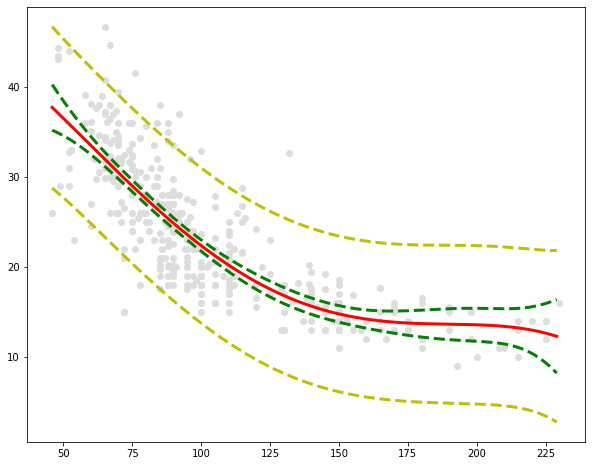

In [25]:
plt.figure(figsize=(10,8))
horsepower_for_plot = np.arange(data.horsepower.min(), data.horsepower.max()).reshape(-1, 1)
horsepower_for_plot = PolynomialFeatures(degree=4).fit_transform(horsepower_for_plot)
model = sm.OLS(data.mpg, PolynomialFeatures(degree=4).fit_transform(data.horsepower.to_frame())).fit()
pred_res = model.get_prediction(horsepower_for_plot).summary_frame()

plt.plot(data.horsepower, data.mpg, 'o', c='#dddddd')
plt.plot(horsepower_for_plot[:, 1], pred_res['mean'], color='r', lw=3)
plt.plot(horsepower_for_plot[:, 1], pred_res['mean_ci_lower'], 'g--', lw=3)
plt.plot(horsepower_for_plot[:, 1], pred_res['mean_ci_upper'], 'g--', lw=3)
plt.plot(horsepower_for_plot[:, 1], pred_res['obs_ci_lower'], 'y--', lw=3)
plt.plot(horsepower_for_plot[:, 1], pred_res['obs_ci_upper'], 'y--', lw=3)

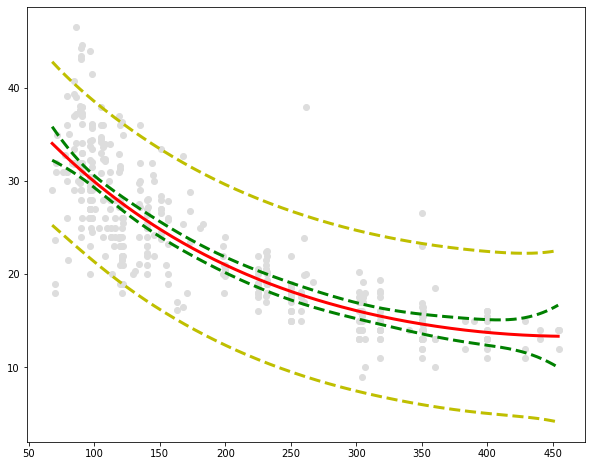

In [26]:
plt.figure(figsize=(10,8))
displacement_for_plot = np.arange(data.displacement.min(), data.displacement.max()).reshape(-1, 1)
displacement_for_plot = PolynomialFeatures(degree=4).fit_transform(displacement_for_plot)
model = sm.OLS(data.mpg, PolynomialFeatures(degree=4).fit_transform(data.displacement.to_frame())).fit()
pred_res = model.get_prediction(displacement_for_plot).summary_frame()

plt.plot(data.displacement, data.mpg, 'o', c='#dddddd')
plt.plot(displacement_for_plot[:, 1], pred_res['mean'], color='r', lw=3)
plt.plot(displacement_for_plot[:, 1], pred_res['mean_ci_lower'], 'g--', lw=3)
plt.plot(displacement_for_plot[:, 1], pred_res['mean_ci_upper'], 'g--', lw=3)
plt.plot(displacement_for_plot[:, 1], pred_res['obs_ci_lower'], 'y--', lw=3)
plt.plot(displacement_for_plot[:, 1], pred_res['obs_ci_upper'], 'y--', lw=3)

# Ex. 9

In [27]:
dataset_file = '../datasets/Boston.csv'
data = pd.read_csv(dataset_file)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nox   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     419.3
Date:                Sun, 27 Sep 2020   Prob (F-statistic):          2.71e-136
Time:                        12:33:30   Log-Likelihood:                 690.44
No. Observations:                 506   AIC:                            -1373.
Df Residuals:                     502   BIC:                            -1356.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9341      0.021     45.110      0.000       0.893       0.975
x1            -0.1821      0.015    -12.389      0.000      -0.211      -0.153
x2             0.0219      0.003      7.476      0.000       0.016       0.028
x3            -0.0009      0.000     -5.124      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       64.176   Durbin-Watson:                   0.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.386
Skew:                           0.917   Prob(JB):                     1.06e-19
Kurtosis:                       3.886   Cond. No.                     2.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

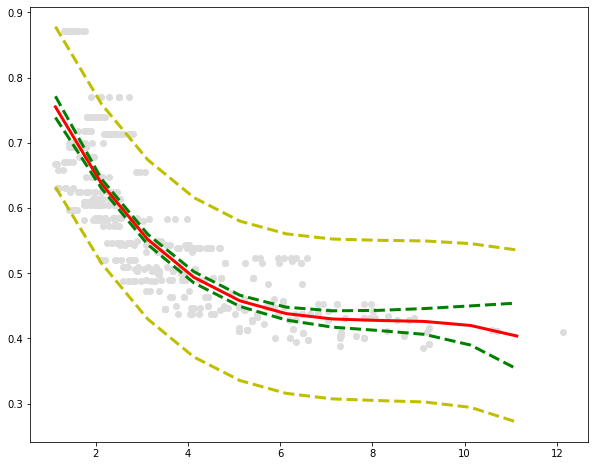

In [28]:
dis_for_plot = np.arange(data.dis.min(), data.dis.max()).reshape(-1, 1)
dis_for_plot = PolynomialFeatures(degree=3).fit_transform(dis_for_plot)
model = sm.OLS(data.nox, PolynomialFeatures(degree=3).fit_transform(data.dis.to_frame())).fit()
pred_res = model.get_prediction(dis_for_plot).summary_frame()

plt.figure(figsize=(10,8))
plt.plot(data.dis, data.nox, 'o', c='#dddddd')
plt.plot(dis_for_plot[:, 1], pred_res['mean'], color='r', lw=3)
plt.plot(dis_for_plot[:, 1], pred_res['mean_ci_lower'], 'g--', lw=3)
plt.plot(dis_for_plot[:, 1], pred_res['mean_ci_upper'], 'g--', lw=3)
plt.plot(dis_for_plot[:, 1], pred_res['obs_ci_lower'], 'y--', lw=3)
plt.plot(dis_for_plot[:, 1], pred_res['obs_ci_upper'], 'y--', lw=3)
model.summary()

Text(0.5, 1.0, 'Best: 3')

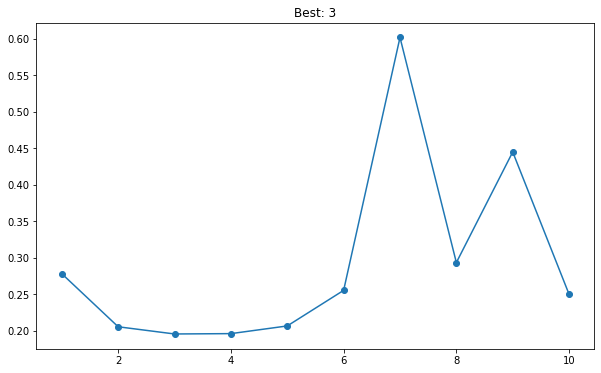

In [29]:
degrees = np.arange(1, 11)
metrics = pd.Series(dtype=np.float64, index=degrees)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
for degree in degrees:
    errors = []
    for train, test in cv.split(data):
        model = sm.OLS(
            data.nox.iloc[train],
            PolynomialFeatures(degree=degree).fit_transform(data.dis.iloc[train].to_frame())
        ).fit()
        rss = ((data.nox.iloc[test] - model.predict(PolynomialFeatures(degree=degree).fit_transform(data.dis.iloc[test].to_frame()))) ** 2).sum()
        errors.append(rss)
    metrics.loc[degree] = np.mean(errors)

plt.figure(figsize=(10,6))
plt.plot(metrics.index, metrics, 'o-')
best_cv = metrics.idxmin()
plt.title(f'Best: {best_cv}')

CV results in a 3 degree polynomial as a best model.

In [30]:
from patsy import dmatrix

In [31]:
dm = dmatrix(
    'bs(dis, knots=(4,8), degree=3, include_intercept=False)',
    {'dis': data.dis}, return_type='dataframe'
)
model = sm.GLM(data.nox, dm).fit()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    nox   No. Observations:                  506
Model:                            GLM   Df Residuals:                      500
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                       0.0038371
Method:                          IRLS   Log-Likelihood:                 692.48
Date:                Sun, 27 Sep 2020   Deviance:                       1.9186
Time:                        12:33:31   Pearson chi2:                     1.92
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       0.7438      0.013     57.156      0.000       0.718       0.769
bs(dis, knots=(4, 8), degree=3, include_intercept=False)[0]    -0.1018      0.024     -4.305      0.000      -0.148      -0.055
bs(dis, knots=(4, 8), degree=3, include_intercept=False)[1]    -0.3355      0.017    -19.497      0.000      -0.369      -0.302
bs(dis, knots=(4, 8), degree=3, include_intercept=False)[2]    -0.2712      0.034     -8.059      0.000      -0.337      -0.205
bs(dis, knots=(4, 8), degree=3, include_intercept=False)[3]    -0.3931      0.045     -8.826      0.000      -0.480      -0.306
bs(dis, knots=(4, 8), degree=3, include_intercept=False)[4]    -0.3124      0.060     -5.166      0.000      -0.431      -0.194
===============================================================================================================================
"""

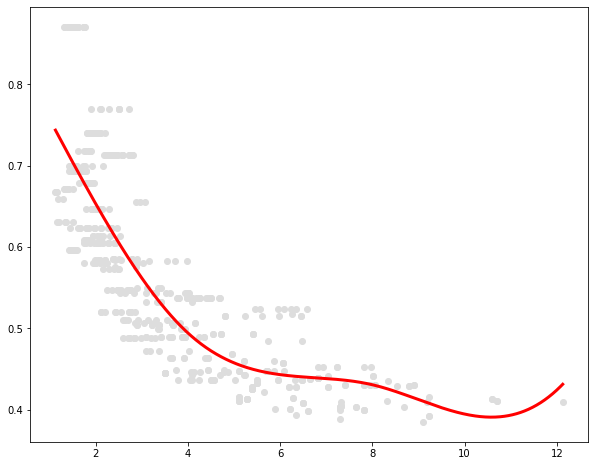

In [32]:
dis_for_plot = np.linspace(data.dis.min(), data.dis.max(), data.dis.size).reshape(-1, 1)
dm_for_plot = dmatrix(
    'bs(dis, knots=(4,8), degree=3, include_intercept=False)',
    {'dis': dis_for_plot}, return_type='dataframe'
)
pred_res = model.predict(dm_for_plot)

plt.figure(figsize=(10,8))
plt.plot(data.dis, data.nox, 'o', c='#dddddd')
plt.plot(dis_for_plot, pred_res, color='r', lw=3)
model.summary()

Text(0.5, 1.0, 'Best: 14')

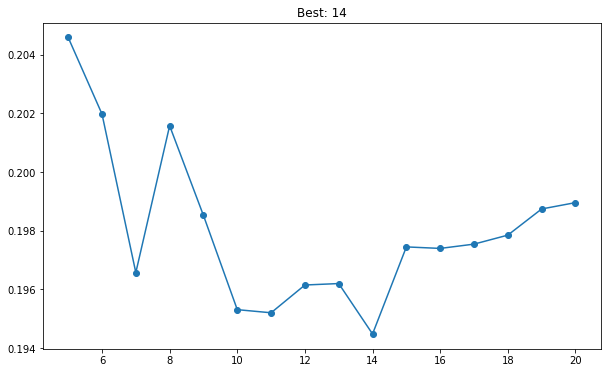

In [33]:
dfs = np.arange(5, 21)
metrics = pd.Series(dtype=np.float64, index=dfs)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
for df in dfs:
    errors = []
    for train, test in cv.split(data):
        dm_train = dmatrix(
            'bs(dis, df=df, degree=3, include_intercept=False)',
            {'dis': data.dis.iloc[train], 'df': df}, return_type='dataframe'
        )
        dm_test = dmatrix(
            'bs(dis, df=df, degree=3, include_intercept=False)',
            {'dis': data.dis.iloc[test], 'df': df}, return_type='dataframe'
        )
        model = sm.GLM(data.nox.iloc[train], dm_train).fit()
        rss = ((data.nox.iloc[test] - model.predict(dm_test)) ** 2).sum()
        errors.append(rss)
    metrics.loc[df] = np.mean(errors)

plt.figure(figsize=(10,6))
plt.plot(metrics.index, metrics, 'o-')
best_cv = metrics.idxmin()
plt.title(f'Best: {best_cv}')

In [34]:
metrics

5     0.204594
6     0.201980
7     0.196574
8     0.201582
9     0.198522
10    0.195309
11    0.195202
12    0.196149
13    0.196199
14    0.194479
15    0.197449
16    0.197398
17    0.197544
18    0.197851
19    0.198743
20    0.198960
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    nox   No. Observations:                  506
Model:                            GLM   Df Residuals:                      491
Model Family:                Gaussian   Df Model:                           14
Link Function:               identity   Scale:                       0.0036290
Method:                          IRLS   Log-Likelihood:                 711.19
Date:                Sun, 27 Sep 2020   Deviance:                       1.7818
Time:                        12:33:35   Pearson chi2:                     1.78
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                 0.6537      0.033     19.933      0.000       0.589       0.718
bs(dis, df=14, degree=3, include_intercept=False)[0]      0.0284      0.062      0.454      0.650      -0.094       0.151
bs(dis, df=14, degree=3, include_intercept=False)[1]      0.0981      0.039      2.514      0.012       0.022       0.175
bs(dis, df=14, degree=3, include_intercept=False)[2]      0.0266      0.041      0.657      0.511      -0.053       0.106
bs(dis, df=14, degree=3, include_intercept=False)[3]     -0.0268      0.036     -0.735      0.462      -0.098       0.045
bs(dis, df=14, degree=3, include_intercept=False)[4]     -0.0254      0.038     -0.664      0.507      -0.100       0.050
bs(dis, df=14, degree=3, include_intercept=False)[5]     -0.0710      0.038     -1.868      0.062      -0.145       0.003
bs(dis, df=14, degree=3, include_intercept=False)[6]     -0.1585      0.040     -4.003      0.000      -0.236      -0.081
bs(dis, df=14, degree=3, include_intercept=False)[7]     -0.1497      0.038     -3.945      0.000      -0.224      -0.075
bs(dis, df=14, degree=3, include_intercept=False)[8]     -0.1470      0.038     -3.820      0.000      -0.222      -0.072
bs(dis, df=14, degree=3, include_intercept=False)[9]     -0.2224      0.038     -5.884      0.000      -0.296      -0.148
bs(dis, df=14, degree=3, include_intercept=False)[10]    -0.1884      0.037     -5.084      0.000      -0.261      -0.116
bs(dis, df=14, degree=3, include_intercept=False)[11]    -0.2794      0.051     -5.468      0.000      -0.380      -0.179
bs(dis, df=14, degree=3, include_intercept=False)[12]    -0.2097      0.073     -2.873      0.004      -0.353      -0.067
bs(dis, df=14, degree=3, include_intercept=False)[13]    -0.2532      0.066     -3.835      0.000      -0.383      -0.124
=========================================================================================================================
"""

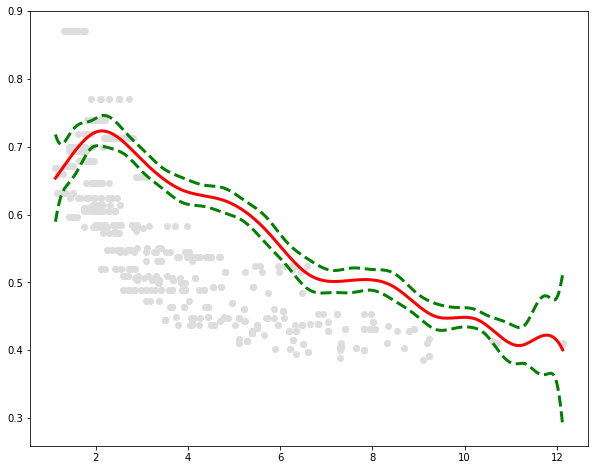

In [35]:
dm = dmatrix(
    'bs(dis, df=14, degree=3, include_intercept=False)',
    {'dis': data.dis}, return_type='dataframe'
)
model = sm.GLM(data.nox, dm).fit()
dis_for_plot = np.linspace(data.dis.min(), data.dis.max(), data.dis.size).reshape(-1, 1)
dm_for_plot = dmatrix(
    'bs(dis, df=14, degree=3, include_intercept=False)',
    {'dis': dis_for_plot}, return_type='dataframe'
)
pred_res = model.get_prediction(dm_for_plot).summary_frame()

plt.figure(figsize=(10,8))
plt.plot(data.dis, data.nox, 'o', c='#dddddd')
plt.plot(dis_for_plot, pred_res['mean'], color='r', lw=3)
plt.plot(dis_for_plot, pred_res['mean_ci_lower'], 'g--', lw=3)
plt.plot(dis_for_plot, pred_res['mean_ci_upper'], 'g--', lw=3)
model.summary()

# Ex. 10

In [72]:
dataset_file = '../datasets/College.csv'
data = pd.read_csv(dataset_file)
data.rename({
    'F.Undergrad': 'F_Undergrad',
    'P.Undergrad': 'P_Undergrad',
    'Room.Board': 'Room_Board',
    'S.F.Ratio': 'S_F_Ratio',
    'perc.alumni': 'perc_alumni',
    'Grad.Rate': 'Grad_Rate'
}, axis=1, inplace=True)
data.Private = data.Private.apply(lambda v: 1 if v == 'Yes' else 0)
data.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,Room_Board,Books,Personal,PhD,Terminal,S_F_Ratio,perc_alumni,Expend,Grad_Rate
0,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [73]:
def forward_stepwise_selection(X, y, verbose=True):
    p = X.shape[1]
    best_of_k = {}
    best_of_k[0] = []
    for k in range(1, p + 1):
        names_candidates = [best_of_k[k - 1] + [name] for name in X.columns if name not in best_of_k[k - 1]]
        models = [(names, sm.OLS(y, sm.add_constant(X[names])).fit().rsquared) for names in names_candidates]
        best_of_k[k] = max(models, key=lambda model: model[1])[0]
        if verbose:
            print(k, best_of_k[k])

    return best_of_k

In [74]:
from sklearn.model_selection import train_test_split

In [103]:
train, test = train_test_split(data, test_size=.5, random_state=228)

In [104]:
best_models = forward_stepwise_selection(train.drop(['Outstate'], axis=1), train.Outstate)

1 ['Expend']
2 ['Expend', 'Room_Board']
3 ['Expend', 'Room_Board', 'Private']
4 ['Expend', 'Room_Board', 'Private', 'Grad_Rate']
5 ['Expend', 'Room_Board', 'Private', 'Grad_Rate', 'Terminal']
6 ['Expend', 'Room_Board', 'Private', 'Grad_Rate', 'Terminal', 'perc_alumni']
7 ['Expend', 'Room_Board', 'Private', 'Grad_Rate', 'Terminal', 'perc_alumni', 'Accept']
8 ['Expend', 'Room_Board', 'Private', 'Grad_Rate', 'Terminal', 'perc_alumni', 'Accept', 'Enroll']
9 ['Expend', 'Room_Board', 'Private', 'Grad_Rate', 'Terminal', 'perc_alumni', 'Accept', 'Enroll', 'Top10perc']
10 ['Expend', 'Room_Board', 'Private', 'Grad_Rate', 'Terminal', 'perc_alumni', 'Accept', 'Enroll', 'Top10perc', 'Apps']
11 ['Expend', 'Room_Board', 'Private', 'Grad_Rate', 'Terminal', 'perc_alumni', 'Accept', 'Enroll', 'Top10perc', 'Apps', 'S_F_Ratio']
12 ['Expend', 'Room_Board', 'Private', 'Grad_Rate', 'Terminal', 'perc_alumni', 'Accept', 'Enroll', 'Top10perc', 'Apps', 'S_F_Ratio', 'Personal']
13 ['Expend', 'Room_Board', 'Privat

['Expend', 'Room_Board', 'Private', 'Grad_Rate', 'Terminal', 'perc_alumni']

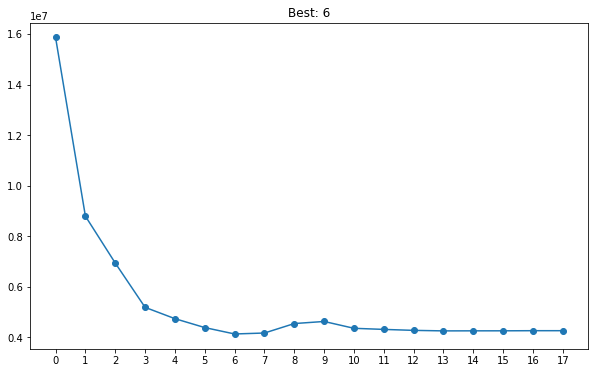

In [105]:
metrics = pd.Series(dtype=np.float64, index=list(best_models.keys()))
train_X = train.drop(['Outstate'], axis=1)
test_X = test.drop(['Outstate'], axis=1)
train_y = train.Outstate
test_y = test.Outstate
for num, names in best_models.items():
    model = sm.OLS(train_y, sm.add_constant(train_X[names])).fit()
    metrics.loc[num] = mean_squared_error(test_y, model.predict(sm.add_constant(test_X[names])))

plt.figure(figsize=(10,6))
plt.plot(metrics.index, metrics, 'o-')
plt.xticks(metrics.index)
best = metrics.idxmin()
plt.title(f'Best: {best}')
best_models[best]

In [134]:
model1 = sm.OLS.from_formula('Outstate~Expend+Room_Board+Private+Grad_Rate+Terminal+perc_alumni', data=train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Outstate   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     186.3
Date:                Sun, 27 Sep 2020   Prob (F-statistic):          4.94e-110
Time:                        16:21:45   Log-Likelihood:                -3508.7
No. Observations:                 388   AIC:                             7031.
Df Residuals:                     381   BIC:                             7059.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4363.9031    681.350     -6.405      0.000   -5703.580   -3024.227
Expend          0.2058      0.024      8.752      0.000       0.160       0.252
Room_Board      0.9482      0.119      7.937      0.000       0.713       1.183
Private      2933.3038    286.347     10.244      0.000    2370.286    3496.322
Grad_Rate      43.3284      7.634      5.675      0.000      28.318      58.339
Terminal       41.3804      8.685      4.765      0.000      24.304      58.457
perc_alumni    21.1371     10.548      2.004      0.046       0.397      41.877
==============================================================================
Omnibus:                        1.718   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.424   Jarque-Bera (JB):                1.561
Skew:                          -0.048   Prob(JB):                        0.458
Kurtosis:                       3.295   Cond. No.                     7.92e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.92e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [136]:
bs = sm.gam.BSplines(train_X[best_models[best]].drop(['Private'], axis=1), df=[4,4,4,4,4], degree=[3,3,3,3,3])
model2 = sm.GLMGam.from_formula(
    'Outstate~Private',
    data=train, smoother=bs, alpha=np.array([0,0,0,0,0])
).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Outstate   No. Observations:                  388
Model:                         GLMGam   Df Residuals:                      371
Model Family:                Gaussian   Df Model:                        16.00
Link Function:               identity   Scale:                      3.6177e+06
Method:                         PIRLS   Log-Likelihood:                -3471.5
Date:                Sun, 27 Sep 2020   Deviance:                   1.3422e+09
Time:                        16:21:59   Pearson chi2:                 1.34e+09
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2127.0516   1814.907      1.172      0.241   -1430.101    5684.204
Private         2408.5151    282.968      8.512      0.000    1853.908    2963.122
Expend_s0       1.382e+04   1767.070      7.819      0.000    1.04e+04    1.73e+04
Expend_s1       6628.4926   2321.883      2.855      0.004    2077.686    1.12e+04
Expend_s2       7866.0523   1974.823      3.983      0.000    3995.470    1.17e+04
Room_Board_s0    702.1221   1917.735      0.366      0.714   -3056.570    4460.814
Room_Board_s1   4610.6219   1191.706      3.869      0.000    2274.922    6946.322
Room_Board_s2   2730.0597   1709.784      1.597      0.110    -621.055    6081.174
Grad_Rate_s0    -696.8772   2066.389     -0.337      0.736   -4746.926    3353.171
Grad_Rate_s1    2410.1665   1025.649      2.350      0.019     399.932    4420.401
Grad_Rate_s2    2416.9693   1248.327      1.936      0.053     -29.707    4863.646
Terminal_s0    -2115.2668   2491.706     -0.849      0.396   -6998.921    2768.387
Terminal_s1     -189.8850   1144.528     -0.166      0.868   -2433.119    2053.349
Terminal_s2     -119.2776   1425.535     -0.084      0.933   -2913.275    2674.720
perc_alumni_s0   416.2557   1483.356      0.281      0.779   -2491.068    3323.579
perc_alumni_s1  -121.6207   1024.466     -0.119      0.906   -2129.538    1886.297
perc_alumni_s2  1614.2501   1303.871      1.238      0.216    -941.289    4169.789
==================================================================================
"""

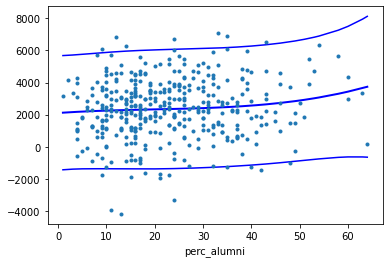

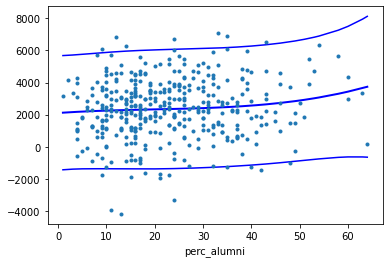

In [152]:
model2.plot_partial(4, cpr=True)

In [138]:
mean_squared_error(test_y, model1.predict(test_X[best_models[best]]))

4135785.071956876

In [166]:
bs = sm.gam.BSplines(test_X[best_models[best]].drop(['Private'], axis=1), df=[4,4,4,4,4], degree=[3,3,3,3,3])
preds = model2.predict(sm.add_constant(test_X.Private), bs.basis, transform=False)
mean_squared_error(test_y, preds)

4145383.9648774527

Models don't seem to outperform each other.

# Ex. 11

In [202]:
np.random.seed(1)
size = 100
X1 = np.random.normal(size=size)
X2 = np.random.normal(size=size)
y = np.random.normal(size=size)
b1 = 5

In [203]:
model = sm.OLS(y - b1 * X1, sm.add_constant(X2)).fit()
b2 = model.params[1]

In [204]:
model = sm.OLS(y - b2 * X2, sm.add_constant(X1)).fit()
model.params[1]

-0.020318635816773165

In [289]:
iters = 10
coefs = np.empty((iters, 3), dtype=float)
b1 = 5
for i in range(iters):
    model = sm.OLS(y - b1 * X1, sm.add_constant(X2)).fit()
    b0, b2 = model.params
    model = sm.OLS(y - b2 * X2, sm.add_constant(X1)).fit()
    b0, b1 = model.params
    coefs[i] = b0, b1, b2

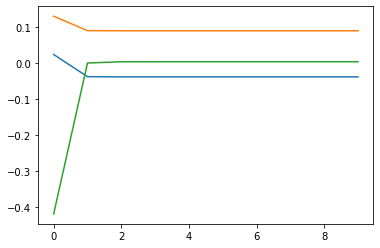

In [290]:
plt.plot(np.arange(iters), coefs[:, 0], label='B0')
plt.plot(np.arange(iters), coefs[:, 1], label='B1')
plt.plot(np.arange(iters), coefs[:, 2], label='B2')

In [291]:
coefs[-1]

array([-0.03908791,  0.0889951 ,  0.00288117])

In [292]:
model = sm.OLS(y, sm.add_constant(np.array([X1, X2]).T)).fit()
model.params

array([-0.03908791,  0.0889951 ,  0.00288117])

It required only one iteration for convergence.

# Ex. 12

In [293]:
np.random.seed(1)
size = 100
p = 101
X = np.empty([p, size], dtype=float)

for i in range(p):
    if i == 0:
        X[i] = np.ones([size,], dtype=float)
    else:
        X[i] = np.random.normal(size=size)
X = X.T
y = np.random.normal(size=size)

In [294]:
%%time
iters = 2000
coefs = np.empty((iters, p), dtype=float)
b = np.ones([p,], dtype=float)

for i in range(iters):
    for j in range(1, p):
        response = y - np.dot(X, b) + b[j] * X[:, j]
        model = sm.OLS(response, sm.add_constant(X[:, j])).fit()
        b[0] = model.params[0]
        b[j] = model.params[1]
    coefs[i] = b

CPU times: user 6min 18s, sys: 4min 30s, total: 10min 49s
Wall time: 2min 46s


In [295]:
model = sm.OLS(y, sm.add_constant(X)).fit()
model.params

array([-1.47587108, -1.44191029, -3.00507233,  2.11839807,  0.60383643,
        0.49988416, -0.17010187,  0.94929221,  0.40606131, -2.94202506,
        0.33542301, -1.00044229, -0.42392226, -0.88045486,  1.89551608,
       -0.89868043,  2.26204626, -0.05924098, -0.24583223,  5.08740123,
       -1.87211257, -3.95741118,  1.93507009,  3.28116738, -2.35140687,
       -3.38902503,  3.20206013,  1.58392332, -1.80823831, -0.84760814,
        0.58203703,  2.46748997,  0.37195892,  2.11955194, -0.20561012,
        1.93964062, -1.84069185,  0.82857004, -0.43772863,  0.39032184,
        1.97156131, -2.38478093,  0.84111516,  2.58840735, -2.33402788,
       -0.77618713,  1.2678895 , -0.00779141, -2.9792121 , -1.79950632,
        3.78701438,  0.06611758,  1.52652707, -1.05711295, -2.79351533,
       -1.23232913, -2.5284673 ,  2.74257991,  0.67996418, -0.41395004,
       -3.25160823,  2.54172364,  0.2921561 ,  1.21709464, -0.64940183,
        0.02248578, -0.708276  , -1.01320496,  0.3651454 ,  0.52

In [296]:
mse = []
for coef in coefs:
    mse.append(mean_squared_error(y, np.dot(X, coef)))

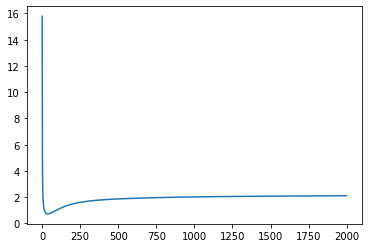

In [297]:
plt.plot(np.arange(iters), mse)

In [298]:
np.argmin(mse)

36

In [300]:
coefs[36]

array([ 1.09251402,  0.76249464, -0.45891104,  0.25389828,  0.08572084,
       -0.86585224,  0.46458015,  0.8550428 ,  0.41239181,  1.1355581 ,
       -0.05549364, -0.33974244,  0.2740312 , -0.30914188, -0.21062529,
        0.0803433 , -0.21035344,  0.02861986,  0.6564633 ,  0.12396278,
        0.11440105,  0.39955905,  1.13135218,  0.13308465,  0.42424873,
        0.03544702,  0.01623435,  0.69715223,  0.63983444, -0.28208141,
        0.37578956, -0.17492373,  0.14881586, -0.3981524 , -0.52527128,
        0.54558401,  0.42415653,  0.04842555, -0.19026636,  0.03014309,
       -0.16776334,  0.41011991,  0.1054373 , -0.04061105,  0.55497603,
        0.37329251, -0.2699371 ,  0.13145792,  0.37584508, -0.08940041,
       -0.11912025,  0.52143832, -0.10367328,  0.44399888,  0.33620174,
       -0.04712391,  0.54092925, -0.46625416, -0.12514269,  0.88376549,
       -0.30446793,  0.03937514, -0.20899972, -0.22228718, -0.16933289,
        0.12425852, -0.8327019 , -0.12324828,  0.4702917 ,  0.15

In [305]:
model.mse_total

0.7308821299454387

In [307]:
min(mse)

0.7276667408259568

Model required 36 iterations to converge. 